In [2]:
import pandas as pd
import data_utils as du

path_to_media = './data/extra_infos.json'
path_to_train = './data/train.csv'

In [3]:
media_info = du.json_to_pandas(path_to_media)
media_info.head()

,alb_title,art_name,media_id,sng_title
0,El Son de Cuba,Septeto Nacional De Ignacio Pineiro,213952,Maria Cristina
1,Sounds from the fourth world,Calvin Russell,223014,Love stealer
2,Le meilleur de Malavoi,Malavoi,237198,Caressé moin
3,Les titres essentiels Cuba,Soneros De Verdad,238380,A Buena Vista
4,Dantzig Twist,Marquis de Sade,244881,Nacht und Nebel


In [4]:
train = pd.read_csv(path_to_train, encoding='utf-8')
train.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29,0
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30,1
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29,1
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30,0
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1


In [5]:
by_artist = train.groupby(['artist_id'], as_index=False).agg({'media_id' : 'count'})
len(by_artist)

67142

Є три типи колонок. Є інформація про користувача: `user_gender`, `user_age`. Є інформація про пісню: назва, альбом, виконавець, `genre_id`, `release_date`, `media_duration`. Є інформація про конкретне прослуховування: `ts_listen`, `platform_name`, `platform_family`, `listen_type`.

Що звідки ми можемо витягнути? Час доби. Чи слухає користувач flow взагалі. 

Як можна кластеризувати користувачів? Скільки разів він слухав кожен з жанрів (порахувати кількість жанрів). В який час любить слухати музику (вечір, робочий час, вихідні). В якому контексті скільки разів він слухав музику. З якої платформи скільки разів він слухав музику. Чи використовує він Flow. І, найскладніше, за спільними музичними уподобаннями.

Для останнього можна спробувати аналіз графа.

#### Питання 1
Чи є розшифровка закодованних полів? (`platform_name`, `platform_family` etc)

#### Feature idea 1 (+++)
Можна з назви пісні, альбома, імені виконавця витащити мову, на якій ця пісня. 100% це буде важлива фіча.
#### Feature idea 2 (+)
Можна взяти як фічу час доби.
#### Feature idea 3 (++++++)
Порівнювати музику за допомогою DBPedia https://link.springer.com/chapter/10.1007%2F978-3-642-13489-0_34?LI=true
#### Feature idea 4 (++)
Побудувати граф по цих данних і визначати відстань від пісні до користувача.
#### Feature idea 5 (+++++)
Витащити з DBPedia жанри цих пісень і натренувати нейронку визначати жанр. Потім дані з останнього шару нейронки використовувати як фічі.

In [24]:
train = pd.read_csv(path_to_train, encoding='utf-8')

In [25]:
len(train["genre_id"].unique())

2922

In [26]:
len(train["user_id"].unique())

19918

In [27]:
len(train["context_type"].unique()) # цікаво, що це за контексти?

74

In [28]:
len(train["platform_name"].unique()) # PC, smartphone, tablet?

3

In [29]:
len(train["platform_family"].unique()) # Windows, android, iOS?

3

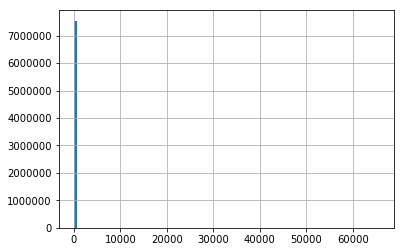

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
train["media_duration"].hist(bins=100)

Дуже дивно виглядає `media_duration`, наче є якісь супер аутлаєри. Може це якісь аудіо книги?

In [31]:
train["media_duration"].describe() 

count    7.558834e+06
mean     2.311527e+02
std      7.999463e+01
min      0.000000e+00
25%      1.960000e+02
50%      2.220000e+02
75%      2.540000e+02
max      6.553500e+04
Name: media_duration, dtype: float64

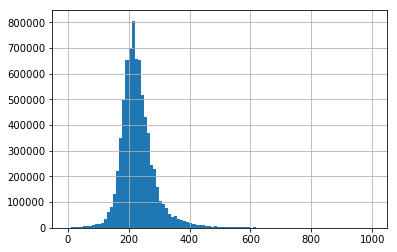

In [32]:
limit = 1000
outliers = train[train['media_duration'] < limit]
outliers['media_duration'].hist(bins=100)

In [33]:
outliers['media_duration']

0          223
1          171
2          149
3          240
4          150
5          150
6          150
7          150
8          150
9          150
10         150
11         150
12         188
13         150
14         150
15         150
16         150
17         150
18         150
19         150
20         150
21         150
22         150
23         150
24         150
25         197
26         210
27         188
28         150
29         150
          ... 
7558804    268
7558805    268
7558806    268
7558807    268
7558808    268
7558809    268
7558810    268
7558811    268
7558812    268
7558813    268
7558814    268
7558815    268
7558816    268
7558817    268
7558818    268
7558819    268
7558820    268
7558821    268
7558822    268
7558823    268
7558824    268
7558825    268
7558826    268
7558827    268
7558828    268
7558829    268
7558830    974
7558831    175
7558832    126
7558833    177
Name: media_duration, dtype: int64

In [34]:
len(outliers['media_duration']) # це явно аудіо книги

7556062

C:\Users\Anatoliy\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


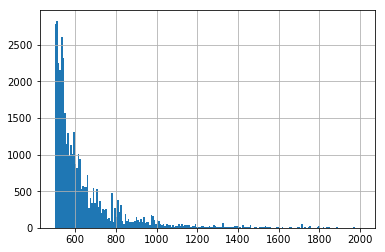

In [35]:
train[train['media_duration'] > 500][train['media_duration'] < 2000]["media_duration"].hist(bins=200)

In [36]:
# подивимося назву
media1 = train[train['media_duration'] > 1000].iloc[0]
media1

genre_id                  109
ts_listen          1478809731
media_id             12092135
album_id              1109711
context_type                0
release_date         20051231
platform_name               1
platform_family             0
media_duration           2822
listen_type                 0
user_gender                 1
user_id                 13389
artist_id              191083
user_age                   25
is_listened                 0
Name: 8341, dtype: int64

In [37]:
media_info[media_info["media_id"] == media1["media_id"]] # ні, це опера!

,alb_title,art_name,media_id,sng_title
157043,Opera in the Outback,Nessun Dorma,12092135,Nessun Dorma


In [38]:
media2 = train[train['media_duration'] > 3000].iloc[0]
media_info[media_info["media_id"] == media2["media_id"]] # а це вже аудіокниги, страх та ненависть

,alb_title,art_name,media_id,sng_title
377284,Fear And Loathing,Luke Slater,38545391,Fear And Loathing - Part 1 (Continuous DJ Mix)


In [39]:
media2["genre_id"]

27

In [40]:
len(train[train["genre_id"] == 27])

187946

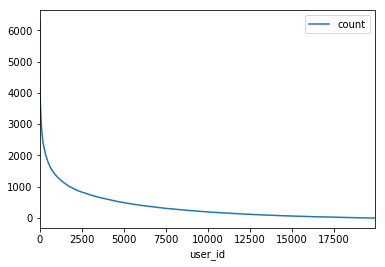

In [41]:
by_user = train.groupby("user_id").agg({'genre_id': 'count'})
by_user['count'] = by_user['genre_id']
del by_user['genre_id']
by_user.plot()

In [45]:
len(by_user[by_user['count'] < 20])

1815

In [43]:
len(train[train["user_id"]==1])

6240